# Esercizio 11.3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import activations

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects


In [87]:

#fixed values for training and data
N_train=500
N_valid=int(100)
N_epoch=50
sigma=0.1

def Generate_Data():
  '''
  generate data for traing and validation of NN
  z=sin(x^2+y^2)
  with a gaussian noise
  '''

  np.random.seed(0)
  x_train = np.random.uniform(-1.5, 1.5, N_train)
  y_train = np.random.uniform(-1.5, 1.5, N_train)

  x_valid= np.random.uniform(-1.5, 1.5, N_train)
  y_valid= np.random.uniform(-1.5, 1.5, N_train)
  #x_valid.sort()
  #y_valid.sort()

  z_target =np.sin( np.power(x_train,2)+np.power(y_train,2) ) #ideal (target) linear function
  z_train = np.random.normal( np.sin( np.power(x_train,2)+np.power(y_train,2) ), sigma) # actual measures from which we want to guess regression parameters
  z_valid = np.random.normal( np.sin( np.power(x_valid,2)+np.power(y_valid,2) ), sigma)
  data={
      "x_train": x_train,
      "y_train": y_train,
      "z_target": z_target,
      "x_valid": x_valid,
      "y_valid": y_valid,
      "z_train": z_train,      
      "z_valid": z_valid

       }
  return data

def Generate_Model(N_layer=1,N_neuron=2,opt="sgd", loss='mse', act='relu'):
  '''
  generate NN model with N_layers, N_neurons per layer with activation funcition and 1 outpu layer with linear activation
  '''
  model = tf.keras.Sequential()
  model.add(Dense(N_neuron, kernel_initializer='normal',input_dim=2,activation=act))
  # The Hidden Layers :
  for i in range(N_layer):
    model.add(Dense(N_neuron/2,kernel_initializer='normal', activation=act))
  # The Output Layer :
  model.add(Dense(1, kernel_initializer='normal',activation='linear'))
  model.compile(optimizer=opt, loss=loss, metrics=['mse'])
  model.summary()

  return model

def NN_test(N_layer=1,N_neuron=2,opt="sgd", loss='mse', act='relu'):
  data=Generate_Data()
  model=Generate_Model(N_layer,N_neuron,opt, loss, act)
  merged_array = np.stack([data["x_train"], data["y_train"]], axis=1)
  history = model.fit(x=merged_array, y=data["z_train"], 
          batch_size=32, epochs=N_epoch,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(merged_array,data["z_valid"]))

  # evaluate
  score = model.evaluate(merged_array,data["z_valid"], batch_size=32, verbose=1)
  score_ec = model.evaluate(merged_array,data["z_target"], batch_size=32, verbose=1)

  #x_predicted = np.random.uniform(-1.3, 1.3, 100)
  #x_predicted.sort()
  #y_target_out =a+b*np.power(x_predicted,1)+c*np.power(x_predicted,2)+d*np.power(x_predicted,3) 

  #score_out=model.evaluate(x_predicted, y_target_out, batch_size=32, verbose=1)

  # print performance
  print()
  print('Test loss:   data_test=', score[0], "  exact curve=", score_ec[0])
  print('Test accuracy:   data_test=', score[1], "  exact curve=", score_ec[1])

  return([data,history,score[0],score_ec[0], model])



def Find_best_NN(N_layers, N_neurons, opt="sgd", loss='mse', act='relu'):
  '''
  Input=sigma
  Test the neural network for different values of N_train and N_epochs for a defined value of sigma
  and give in output al the training values and the best NN 
  Output= TEST : list of all values relative the test
          history: history of the best NN run
          data: all data relative to values of the best run 
          model: best NN model
  '''
  v=["N_layers","N_neurons","opt","act", "loss", "loss_VD","loss_EC", 'loss_out']
  TEST=pd.DataFrame(columns=v)
  for N_layer in N_layers:
    
    losses_EC=np.zeros(len(N_neurons))
    losses_VD=np.zeros(len(N_neurons))

    i=0
    for N_neuron in N_neurons:
      data,history, test_loss, loss_ec, loss_out, model=NN_test(N_layer,N_neuron,opt, loss, act)
      losses_VD[i]=test_loss
      losses_EC[i]=loss_ec
      print("")
      print("N_neuron=", N_neuron, "  loss=", test_loss)
      print("")

      i=i+1
      if(N_neuron==N_neurons[0] and N_layer==N_layers[0]):
        N_layer_best=N_layer
        N_neuron_best=N_neuron
        data_best=data 
        history_best=history 
        model_best=model
        loss_check=test_loss

      if test_loss<loss_check:
        N_layer_best=N_layer
        N_neuron_best=N_neuron
        data_best=data 
        history_best=history 
        model_best=model
        loss_check=test_loss
      TEST.loc[len(TEST.index)] = [N_layer, N_neuron, opt,act,loss, test_loss, loss_ec, loss_out]
    #TEST.loc[len(TEST.index)] = [N_layer, N_neurons, opt,act,loss, losses_VD, losses_EC]

  return TEST, history_best, data_best, model_best, N_neuron_best, N_layer_best

In [132]:
from matplotlib import cm
def plot_NN(history, data, model):
  fig,ax=plt.subplots(1,1,figsize=(15,6))
  ax.plot(history.history['loss'])
  ax.plot(history.history['val_loss'])
  ax.set_title('Model loss')
  ax.set_ylabel('Loss')
  ax.set_xlabel('Epoch')
  ax.legend(['Train', 'Test'], loc='best')
  ax.grid(True)
  plt.show()



  x = np.random.uniform(-1.5, 1.5, 300)
  y = np.random.uniform(-1.5, 1.5, 300)
  merged_array = np.stack([x, y], axis=1)
  z = model.predict(merged_array)[0:,0]
  X=np.arange(-1.5,1.5,0.05)
  Y=np.arange(-1.5,1.5,0.05)

  X, Y = np.meshgrid(X, Y)
  z_target =np.sin( np.power(X,2)+np.power(Y,2) ) #ideal (target) linear function

  # syntax for 3-D projection
  #ax = plt.axes(projection ='3d')
  # plotting
  
  fig = plt.figure(figsize=(15,6))
  ax = fig.gca(projection='3d')

  surf = ax.plot_surface(X, Y, z_target, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.2)
  fig.colorbar(surf, shrink=0.5, aspect=5)
  
  ax.scatter(x, y, z, 'green', label="predicted")
  ax.set_title('3D NN prediction')
  ax.view_init(50, 30)
  ax.legend()
  plt.show()


  fig = plt.figure(figsize=(15,6))
  ax = fig.gca(projection='3d')

  surf = ax.plot_surface(X, Y, z_target, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.2)
  fig.colorbar(surf, shrink=0.5, aspect=5)
  
  ax.scatter(x, y, z, 'green', label="predicted")
  ax.set_title('3D NN prediction')
  ax.view_init(10, 80)
  ax.legend()
  plt.show()



def plot_grid(TEST):
  Loss_VD =np.zeros( (len(N_layers) ,len(N_neurons)))
  Loss_EC =np.zeros( (len(N_layers) ,len(N_neurons)))
  Loss_out=np.zeros( (len(N_layers) ,len(N_neurons)))
  i=0
  for N_layer in N_layers:
      Loss_VD[i]=TEST.loc[TEST["N_layers"]==N_layer, "loss_VD"].to_numpy()
      Loss_EC[i]=TEST.loc[TEST["N_layers"]==N_layer, 'loss_EC'].to_numpy()
      Loss_out[i]=TEST.loc[TEST["N_layers"]==N_layer, 'loss_out'].to_numpy()

      i=i+1
  Loss_VD=np.array(Loss_VD)
  Loss_EC=np.array(Loss_EC)
  Loss_out=np.array(Loss_out)

  MAX=np.max([np.max(Loss_VD), np.max(Loss_EC)])

  plt.figure(figsize=(19,5))
  extent = np.min(N_neurons), np.max(N_neurons), np.max(N_layers), np.min(N_layers)

  plt.subplot(131)
  plt.imshow(Loss_VD, extent=extent,vmin=0, vmax=MAX, cmap='jet', aspect='auto')
  plt.title("validation data loss")
  plt.colorbar()

  plt.subplot(132)
  plt.imshow(Loss_EC, extent=extent,vmin=0, vmax=MAX, cmap='jet', aspect= 'auto')
  plt.title("exact curve loss")
  plt.colorbar()

  plt.subplot(133)
  plt.imshow(Loss_out, extent=extent,vmin=0, vmax= np.max(Loss_out), cmap='jet', aspect= 'auto')
  plt.title("curve loss out training range")
  plt.colorbar()
  plt.show()

def plot(NN):
  TEST, history_best, data_best, model_best, N_neuron_best, N_layers_best=NN
  plot_grid(TEST)
  print()
  print()
  print()
  print("BEST MODEL")
  print("best number of layers=",N_layers_best,"  best number of neurons",  N_neuron_best)
  plot_NN(history_best, data_best, model_best)



In [ ]:
N_neurons=[1024]
N_layers=[1]
opt="adam"
loss='msle'
act='relu'
NN1=NN_test(N_layers[0], N_neurons[0], opt, loss, act)

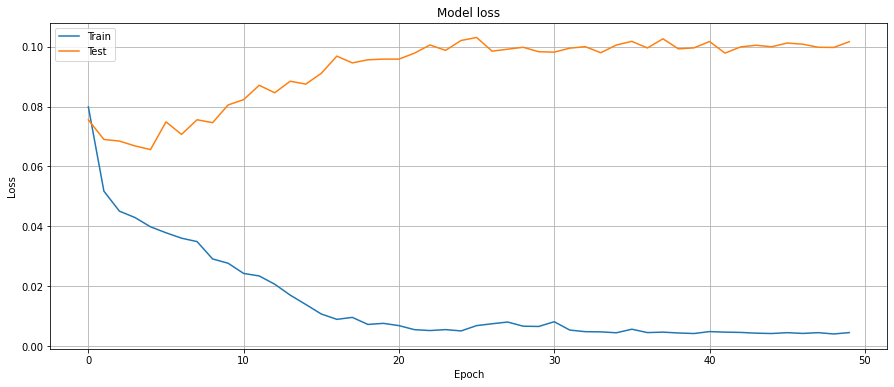

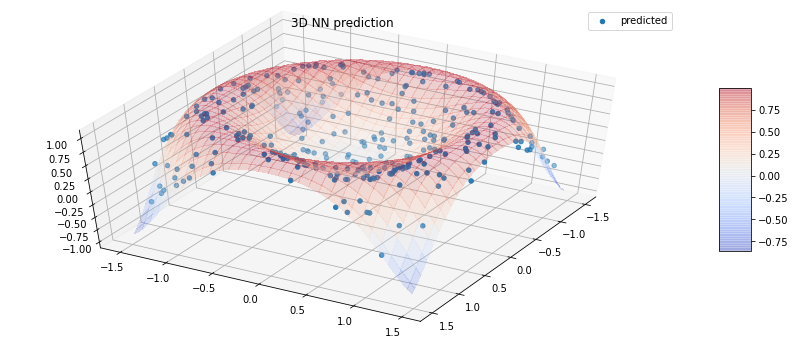

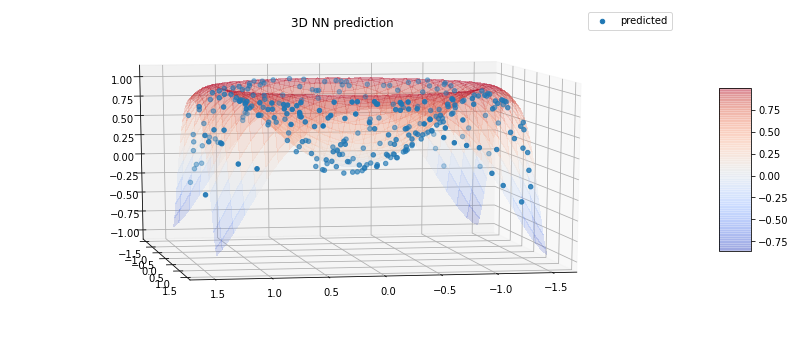

In [133]:
data,history,score,score_ec, model=NN1

plot_NN(history,data, model)

In [ ]:
N_neurons=[512]
N_layers=[3]
opt="adam"
loss='mse'
act='relu'
NN1=NN_test(N_layers[0], N_neurons[0], opt, loss, act)

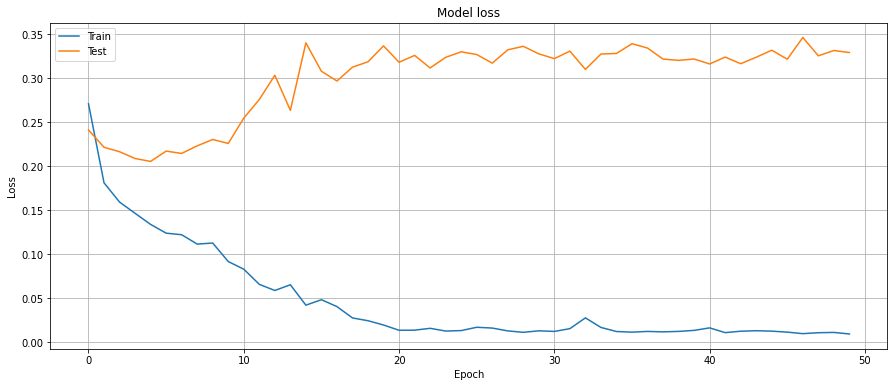

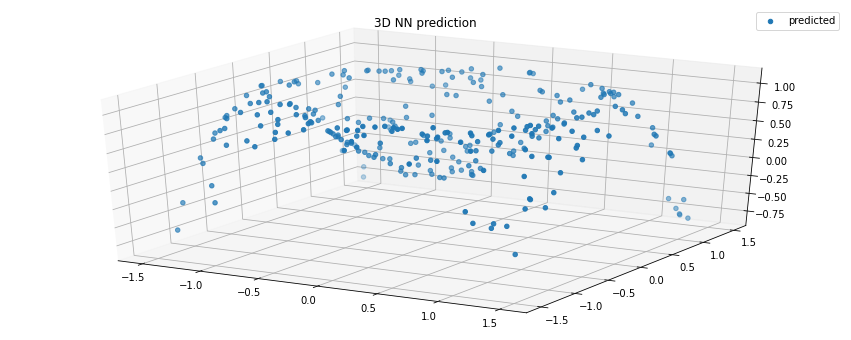

In [102]:
data,history,score,score_ec, model=NN1

plot_NN(history,data, model)